# Look at the himawari-8 AHI raw data from NCI

From Kurihara et al., 2016: IR bands centered at 3.9, 8.6, 10.4, 11.2, and 12.4 μm

8.6 um = Band 11
10.4 = Band 13


NCI opendap data catalog example:

http://dapds00.nci.org.au/thredds/rr5/satellite/obs/himawari8/FLDK/2020/02/07/0400/catalog.html

!pip install --user xarray netcdf4 h5netcdf

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp2d
from pyproj import Proj
import cmocean as cm

In [2]:
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['font.size'] = 14


# Open multiple opendap files

See:
    https://rabernat.github.io/research_computing_2018/xarray-tips-and-triinterp2d
    
    

In [3]:
def get_hw8_ncistr(band, yyyy, mm, dd, hhmm):
    #ncipath = 'http://dapds00.nci.org.au/thredds/dodsC/rr5/satellite/obs/himawari8/FLDK/'
    #hstr = '00-P1S-ABOM_OBS_B{}-PRJ_GEOS141_2000-HIMAWARI8-AHI.nc'.format(band)
    
    ncipath = 'https://dapds00.nci.org.au/thredds/dodsC/ra22/satellite-products/nrt/obs/himawari-ahi/fldk/v1-0/'
    hstr = '00-P1S-ABOM_OBS_B{}-PRJ_GEOS141_2000-HIMAWARI9-AHI.nc'.format(band)

    timestr = '{}/{}/{}/{}/{}{}{}{}{}'.format(yyyy,mm,dd,hhmm,yyyy,mm,dd,hhmm,hstr)
    fullurl = '{}{}'.format(ncipath,timestr)
    return fullurl

In [4]:
########
# Change these inputs
t1 = '2023-08-05 00:00:00'
t2 = '2023-08-08 00:00:00'
date = '20230805' # label for movies

lon1, lon2 = 121.5,124
lat1,lat2 = -15,-12.5

channel = 14

vmin = 21 #23
vmax = 24 #26
########

times = pd.date_range(t1,t2,freq='600S')
url = []
for tt in times:
    hhmm = '%02d%02d'%(tt.hour,tt.minute)
    url.append(get_hw8_ncistr(channel, str(tt.year), '%02d'%(tt.month), '%02d'%(tt.day), hhmm))

In [5]:
# Checks which files are on the server and cull any that are missing
import requests 

def get_status(url):
    return requests.get(url+'.html').status_code

goodurl = []
    
for ff in url:
    status = get_status(ff)
    if status != 200:
        print(ff)
    else:
        goodurl.append(ff)
    

https://dapds00.nci.org.au/thredds/dodsC/ra22/satellite-products/nrt/obs/himawari-ahi/fldk/v1-0/2023/08/05/0000/20230805000000-P1S-ABOM_OBS_B14-PRJ_GEOS141_2000-HIMAWARI9-AHI.nc
https://dapds00.nci.org.au/thredds/dodsC/ra22/satellite-products/nrt/obs/himawari-ahi/fldk/v1-0/2023/08/05/0010/20230805001000-P1S-ABOM_OBS_B14-PRJ_GEOS141_2000-HIMAWARI9-AHI.nc
https://dapds00.nci.org.au/thredds/dodsC/ra22/satellite-products/nrt/obs/himawari-ahi/fldk/v1-0/2023/08/05/0020/20230805002000-P1S-ABOM_OBS_B14-PRJ_GEOS141_2000-HIMAWARI9-AHI.nc
https://dapds00.nci.org.au/thredds/dodsC/ra22/satellite-products/nrt/obs/himawari-ahi/fldk/v1-0/2023/08/05/0030/20230805003000-P1S-ABOM_OBS_B14-PRJ_GEOS141_2000-HIMAWARI9-AHI.nc
https://dapds00.nci.org.au/thredds/dodsC/ra22/satellite-products/nrt/obs/himawari-ahi/fldk/v1-0/2023/08/05/0240/20230805024000-P1S-ABOM_OBS_B14-PRJ_GEOS141_2000-HIMAWARI9-AHI.nc
https://dapds00.nci.org.au/thredds/dodsC/ra22/satellite-products/nrt/obs/himawari-ahi/fldk/v1-0/2023/08/05/061

In [57]:
len(goodurl)

409

In [58]:
dsmf = xr.open_mfdataset(goodurl)
dsmf

<xarray.Dataset>
Dimensions:                              (time: 409, y: 5500, x: 5500)
Coordinates:
  * time                                 (time) datetime64[ns] 2023-08-05T00:...
  * y                                    (y) float64 5.499e+06 ... -5.499e+06
  * x                                    (x) float64 -5.499e+06 ... 5.499e+06
Data variables:
    geostationary                        (time) float32 9.969e+36 ... 9.969e+36
    scan_line_time                       (time, y) datetime64[ns] dask.array<chunksize=(1, 5500), meta=np.ndarray>
    channel_0014_brightness_temperature  (time, y, x) float32 dask.array<chunksize=(1, 5500, 5500), meta=np.ndarray>
Attributes: (12/58)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    acknowledgment:                  See disclaimer
    cdm_data_type:                   grid
    comment:                         AGLS observations geometry product
    contributor_name:                Commonwealth of Australia, Bureau of Met...
    ...                              ...
    platform:                        Himawari-9
    platform_launch_date:            20161102T062000Z
    time_coverage_end:               20230805T004940Z
    time_coverage_start:             20230805T004021Z
    wmo_platform_name:               Himawari-9
    wmo_satellite_number:            174

In [59]:
# Subset the data
#
# 1) Reproject the lat/lon bounds to grid project
# 2) Find the grid i/j points
# 3) 

X,Y = np.meshgrid(dsmf.x.values, dsmf.y.values)
P = Proj(dsmf.geostationary.proj4)

x1,y1 = P(lon1,lat1)
x2,y2 = P(lon2,lat2)

def find_nearest(xx,yy,xp,yp):
    dist = np.sqrt ( (xx-xp)**2 + (yy-yp)**2)
    JI = np.argwhere(dist==dist.min())
    
    return JI[0,0], JI[0,1]

J1,I1 = find_nearest(X,Y, x1, y1)
J2,I2 = find_nearest(X,Y, x2, y2)

x = X[J2:J1,I1:I2]
y = Y[J2:J1,I1:I2]
lon,lat = P(x,y, inverse=True)
lon
myds = dsmf.isel(x=slice(I1,I2), y=slice(J2,J1))#.assign_coords({'x':lon[-1,:], 'y':lat[:,0]})
myds

<xarray.Dataset>
Dimensions:                              (time: 409, y: 129, x: 113)
Coordinates:
  * time                                 (time) datetime64[ns] 2023-08-05T00:...
  * y                                    (y) float64 -1.353e+06 ... -1.609e+06
  * x                                    (x) float64 -1.993e+06 ... -1.769e+06
Data variables:
    geostationary                        (time) float32 9.969e+36 ... 9.969e+36
    scan_line_time                       (time, y) datetime64[ns] dask.array<chunksize=(1, 129), meta=np.ndarray>
    channel_0014_brightness_temperature  (time, y, x) float32 dask.array<chunksize=(1, 129, 113), meta=np.ndarray>
Attributes: (12/58)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    acknowledgment:                  See disclaimer
    cdm_data_type:                   grid
    comment:                         AGLS observations geometry product
    contributor_name:                Commonwealth of Australia, Bureau of Met...
    ...                              ...
    platform:                        Himawari-9
    platform_launch_date:            20161102T062000Z
    time_coverage_end:               20230805T004940Z
    time_coverage_start:             20230805T004021Z
    wmo_platform_name:               Himawari-9
    wmo_satellite_number:            174

In [60]:
# Add the 2D coordinates (for plotting)
myds = myds.assign_coords({
    "lat": (["y", "x"], lat),
    "lon": (["y", "x"], lon)
})
myds

<xarray.Dataset>
Dimensions:                              (time: 409, y: 129, x: 113)
Coordinates:
  * time                                 (time) datetime64[ns] 2023-08-05T00:...
  * y                                    (y) float64 -1.353e+06 ... -1.609e+06
  * x                                    (x) float64 -1.993e+06 ... -1.769e+06
    lat                                  (y, x) float64 -12.53 -12.53 ... -14.94
    lon                                  (y, x) float64 121.7 121.8 ... 123.8
Data variables:
    geostationary                        (time) float32 9.969e+36 ... 9.969e+36
    scan_line_time                       (time, y) datetime64[ns] dask.array<chunksize=(1, 129), meta=np.ndarray>
    channel_0014_brightness_temperature  (time, y, x) float32 dask.array<chunksize=(1, 129, 113), meta=np.ndarray>
Attributes: (12/58)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    acknowledgment:                  See disclaimer
    cdm_data_type:                   grid
    comment:                         AGLS observations geometry product
    contributor_name:                Commonwealth of Australia, Bureau of Met...
    ...                              ...
    platform:                        Himawari-9
    platform_launch_date:            20161102T062000Z
    time_coverage_end:               20230805T004940Z
    time_coverage_start:             20230805T004021Z
    wmo_platform_name:               Himawari-9
    wmo_satellite_number:            174

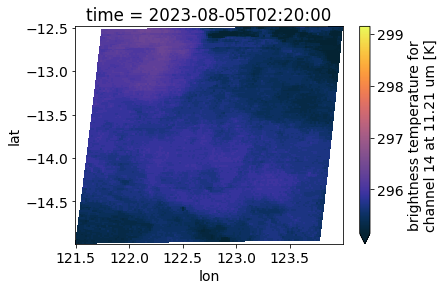

In [61]:
myds['channel_{:04d}_brightness_temperature'.format(channel)][10,...].plot(x='lon', y='lat',
            cmap=cm.cm.thermal ,                                           
            vmin=22+273.15, vmax= 26+273.15)

# Make movies of the raw data

In [62]:
from xmovie import Movie

<Figure size 576x432 with 0 Axes>

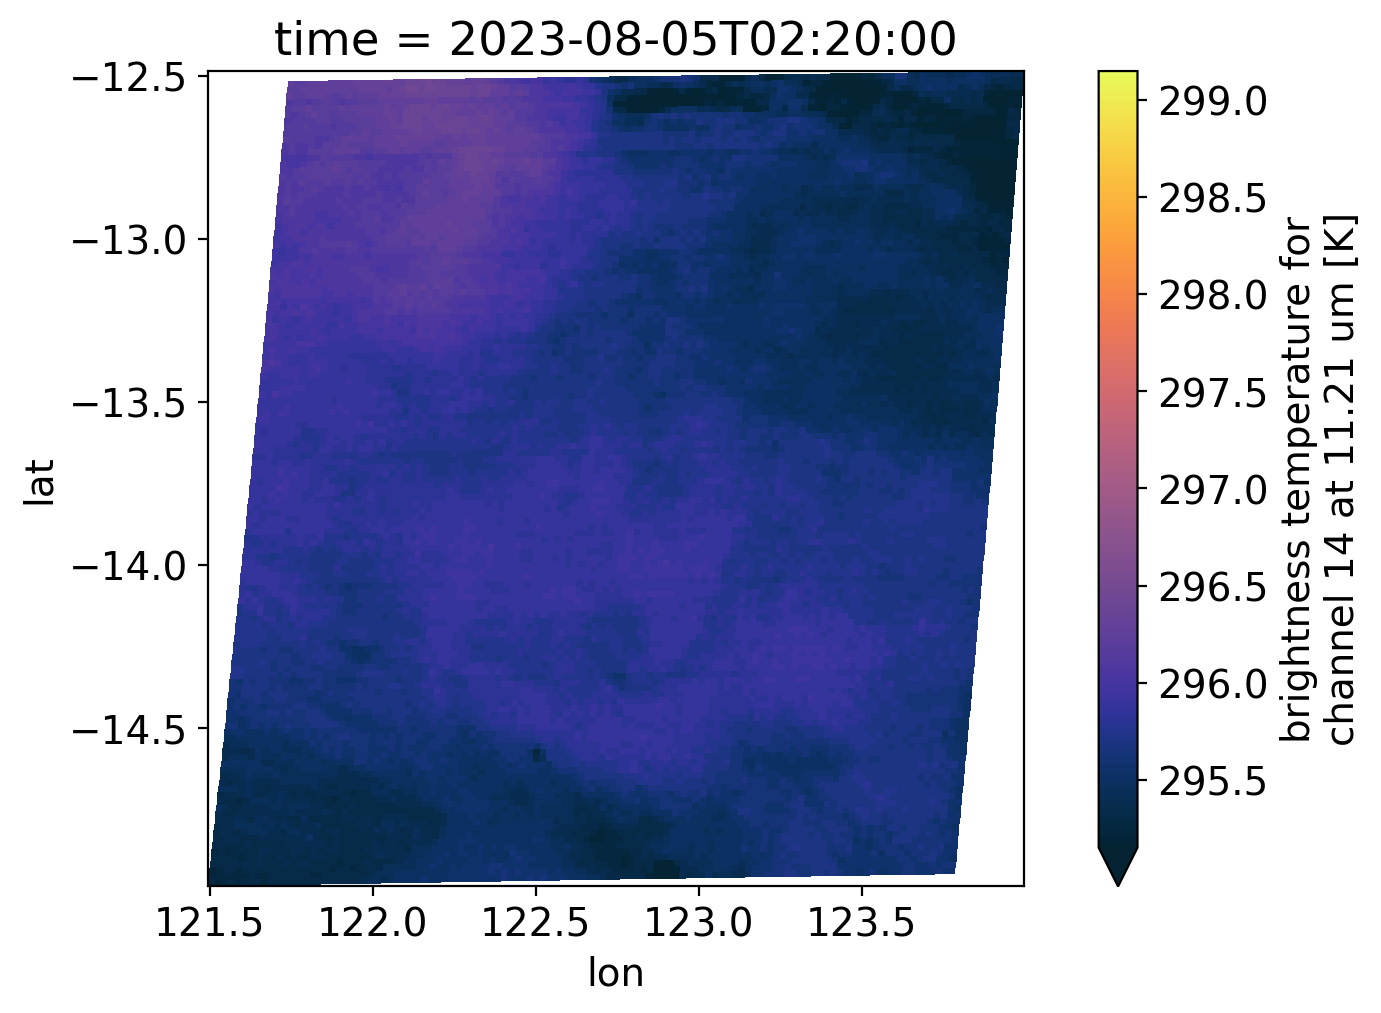

In [63]:
def custom_plotfunc(ds, fig, tt, *args, **kwargs):
    ds.isel(time=tt).plot(x='lon', y='lat',
            cmap=cm.cm.thermal, vmin=kwargs['vmin'], vmax=kwargs['vmax'] )
    plt.gca().set_aspect('equal')

    return None, None

fig=plt.figure(figsize=(8,6))
mov_custom = Movie(myds['channel_{:04d}_brightness_temperature'.format(channel)], custom_plotfunc,                                          
            vmin=22+273.15, vmax= 26+273.15)
mov_custom.preview(10)

In [64]:
# mov_custom.save('../FIGURES/himawari_raw_{}.mp4'.format(date), progress=True)

# Time-average and quality control

In [65]:
myds_1h = myds.resample(time='1H').mean()

fig=plt.figure(figsize=(8,6))
mov_custom = Movie(myds_1h['channel_{:04d}_brightness_temperature'.format(channel)], custom_plotfunc,                                          
            vmin=22+273.15, vmax= 26+273.15)

#mov_custom.save('../FIGURES/himawari_1H_{}.mp4'.format(date), progress=True)

<Figure size 576x432 with 0 Axes>

In [66]:
# Mask clouds using the time derivative i.e. assume that clouds have large dT/dt relative to the ocean

T = myds['channel_{:04d}_brightness_temperature'.format(channel)].chunk({'time':-1}).load()
dTdt = T.differentiate('time', datetime_unit='s')



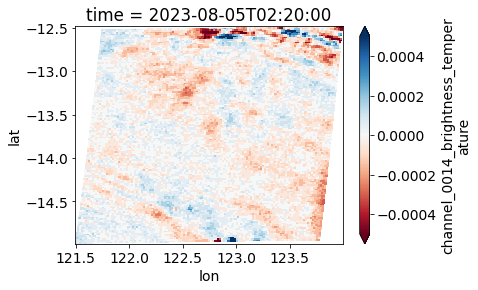

In [67]:
dTdt[10,...].plot(x='lon', y='lat',
            cmap='RdBu' ,
                vmin=-5e-4, vmax=5e-4
)

In [68]:
def custom_plotfunc2(ds, fig, tt, *args, **kwargs):
    ds.isel(time=tt).plot(x='lon', y='lat',
            cmap='RdBu', vmin=kwargs['vmin'], vmax=kwargs['vmax'] )
    plt.gca().set_aspect('equal')

    return None, None

fig=plt.figure(figsize=(8,6))
mov_custom = Movie(dTdt, custom_plotfunc2,                                          
            vmin=-5e-4, vmax=5e-4)

# mov_custom.save('../FIGURES/himawari_dTdt_{}.mp4'.format(date), progress=True)

<Figure size 576x432 with 0 Axes>

In [69]:
Tqc = T.where(np.abs(dTdt)<5e-4)


In [70]:
Tqc_1h = Tqc.resample(time='1H').mean()

<Figure size 576x432 with 0 Axes>

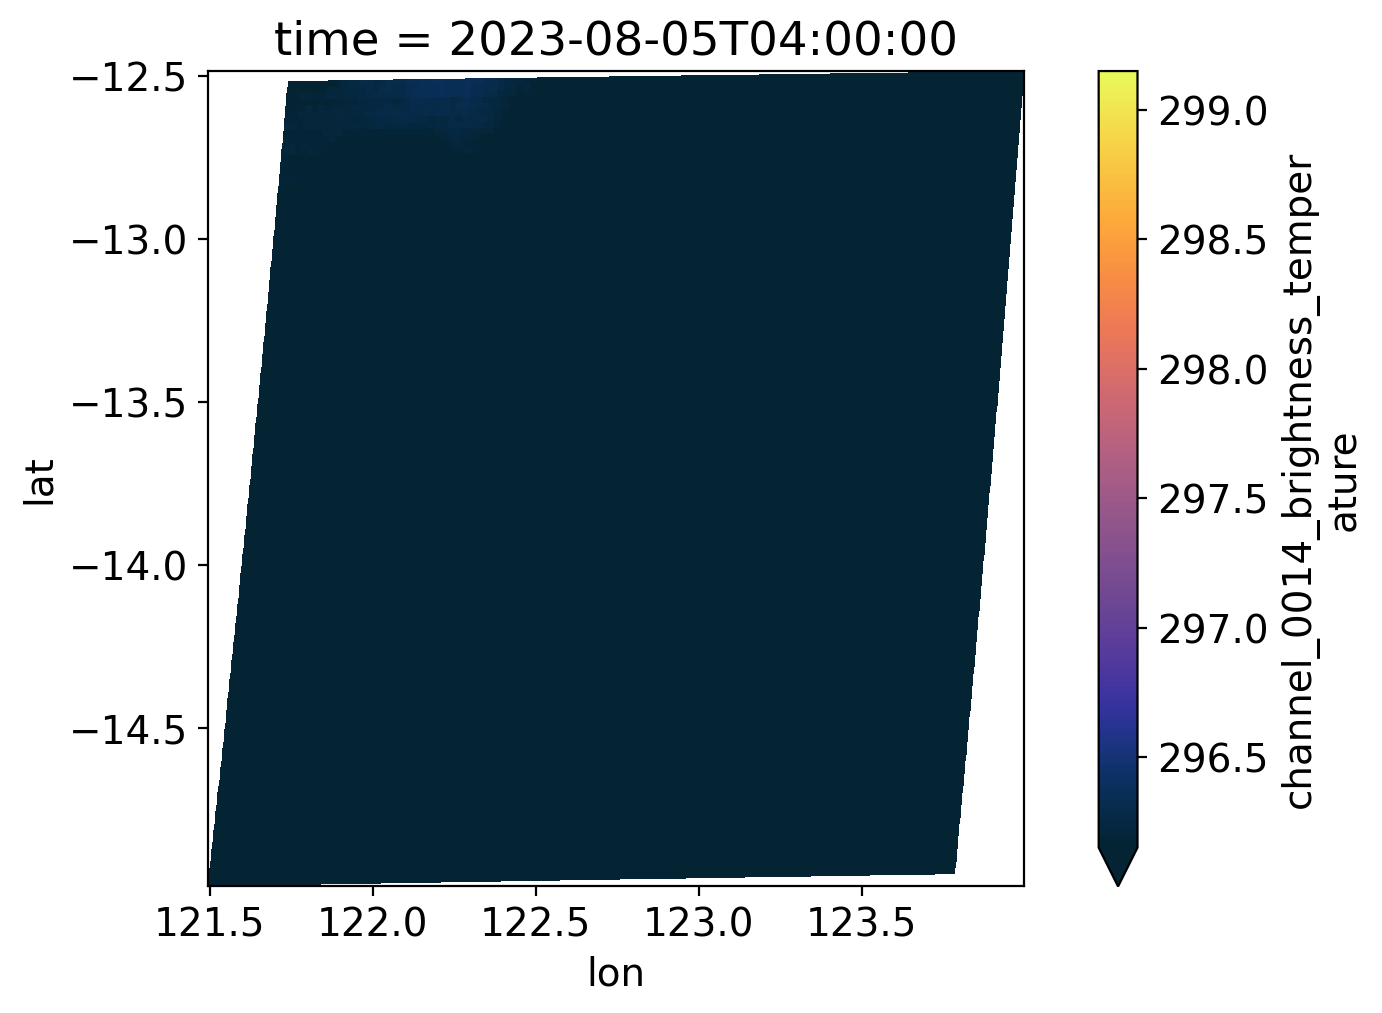

In [71]:
fig=plt.figure(figsize=(8,6))
mov_custom = Movie(Tqc_1h, custom_plotfunc,                                          
            vmin=23+273.15, vmax= 26+273.15)
mov_custom.preview(4)

In [72]:
dTdx = Tqc_1h.differentiate('x')*1e3
dTdy = Tqc_1h.differentiate('y')*1e3
dTgrad = np.abs(dTdx+1j*dTdy)

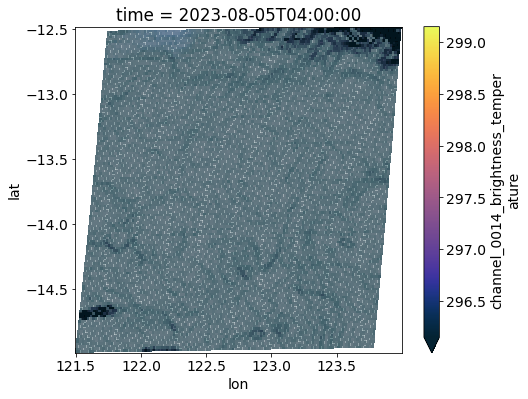

In [73]:
tt=4
fig=plt.figure(figsize=(8,6))
Tqc_1h[tt,...].plot(x='lon', y='lat',
            cmap=cm.cm.thermal,
                vmin=23+273.15, vmax= 26+273.15
)
dTgrad[tt,...].plot(x='lon', y='lat',
            cmap='bone_r' ,
                vmin=0, vmax=0.1, alpha=0.4,
                    add_colorbar=False,
)
plt.gca().set_aspect('equal')

In [74]:
dsout = xr.Dataset({'Tqc':Tqc_1h, 'dTgrad':dTgrad})
dsout

<xarray.Dataset>
Dimensions:  (time: 73, y: 129, x: 113)
Coordinates:
  * time     (time) datetime64[ns] 2023-08-05 2023-08-05T01:00:00 ... 2023-08-08
  * y        (y) float64 -1.353e+06 -1.355e+06 ... -1.607e+06 -1.609e+06
  * x        (x) float64 -1.993e+06 -1.991e+06 ... -1.771e+06 -1.769e+06
    lat      (y, x) float64 -12.53 -12.53 -12.53 -12.52 ... -14.94 -14.94 -14.94
    lon      (y, x) float64 121.7 121.8 121.8 121.8 ... 123.7 123.7 123.8 123.8
Data variables:
    Tqc      (time, y, x) float32 295.8 295.8 295.8 295.8 ... 296.4 296.4 296.4
    dTgrad   (time, y, x) float32 0.01562 0.01747 0.01562 ... 0.01562 0.0 0.0

In [75]:
def custom_plotfunc4(ds, fig, tt, *args, **kwargs):
    ds['Tqc'].isel(time=tt).plot(x='lon', y='lat',
            cmap=cm.cm.thermal, vmin=kwargs['vmin'], vmax=kwargs['vmax'] )
    
    ds['dTgrad'].isel(time=tt).plot(x='lon', y='lat',
             cmap='bone_r', alpha=0.4, vmin=0, vmax=0.1 , add_colorbar=False)
    

    return None, None

fig=plt.figure(figsize=(8,6))
mov_custom = Movie(dsout, custom_plotfunc4,                                          
           vmin=vmin+273.15, vmax= vmax+273.15, input_check=False)
#mov_custom.preview(12)
# mov_custom.save('../FIGURES/himawari_dTgrad_{}.mp4'.format(date), progress=True)

<Figure size 576x432 with 0 Axes>

In [76]:
import geopandas as gpd
import xarray as xr
# Add bathy etc to the plot
basedir = '../../MNF_SWOT/GIS'
swathpoly = gpd.read_file("{}/SWOT_calval_Browse_overpass_swath.shp".format(basedir))
swathline = gpd.read_file("{}/SWOT_calval_Browse_overpass_nadir.shp".format(basedir))

# Load some bathy data
dsZ = xr.open_dataset('~/data/Bathymetry/GA_WEL_NWS_250m_DEM.nc')

# dsZ = dsZ.assign_coords({
#     "X": (["ny"], dsZ.Y.values),
#     "Y": (["nx"], dsZ.X.values)
# })



In [77]:
fig=plt.figure(figsize=(8,6))
 
def custom_plotfunc5(ds, fig, tt, *args, **kwargs):
    ax=fig.subplots()
    ds['Tqc'].isel(time=tt).plot(x='lon', y='lat', ax=ax,
            cmap=cm.cm.thermal, vmin=kwargs['vmin'], vmax=kwargs['vmax'] )

    ds['dTgrad'].isel(time=tt).plot(x='lon', y='lat', ax=ax,
             cmap='bone_r', alpha=0.4, vmin=0, vmax=0.1 , add_colorbar=False)
    
    ax=plt.gca()
    c= plt.contour(dsZ['X'],dsZ['Y'],-dsZ['topo'],[100,200,300,400, 500],colors='k',linewidths=0.5)
    # c= plt.contour(dsZ['X'],dsZ['Y'],-dsZ['topo'],np.arange(100,500,10),colors='0.5',linewidths=0.2)

    p1=plt.plot(123.16238333,-14.23543333,'rd') # BRB200 mooring=
    p4=plt.plot(123.03041737634493, -14.230653066337094,'bd') # S245
    p5=plt.plot(122.8370658081835, -14.13718816307405,'bd') # W310
    p6=plt.plot(123.02928797854348, -14.052341197573492,'bd') # N280

    p2=swathpoly.plot(ax=ax, facecolor='#859101', alpha=0.25, zorder=1e6)


    plt.xlim((lon1,lon2))
    plt.ylim((lat1,lat2))
    ax.set_aspect('equal')  

    return None, None

mov_custom = Movie(dsout, custom_plotfunc5,                                          
           vmin=vmin+273.15, vmax= vmax+273.15, input_check=False)

#mov_custom.preview(4)
mov_custom.save('../FIGURES/himawari_dTgrad_wSites_{}.mp4'.format(date), progress=True)

  0%|          | 0/73 [00:00<?, ?it/s]

Movie created at himawari_dTgrad_wSites_20230805.mp4


<Figure size 576x432 with 0 Axes>

In [78]:

ax

NameError: name 'ax' is not defined